In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Input, layers
from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from spektral.layers import GCNConv

from preprocess.BaselinePrerocess import gcn_process
from preprocess.graph import graph_topology
from baselines.gcn import gcn

2023-07-29 23:47:10.444984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 23:47:11.777692: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Parameters

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5


# ===== model parameters ======
gcn_unit1 = 32
gcn_unit2 = 16
lstm_units = 32
dropout = 0
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

### Preprocess

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = gcn_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 14, 96) (9634, 14, 96) (19268, 14, 96) (77069, 96) (9634, 96) (19268, 96)


### Graph topology

In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [ 0  0  0  0  0  1  1  1  2  2  2  3  3  4  4  4  4  5  5  5  6  6  6  7
  7  7  8  8  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 12 13 13 13 13
 13 13 13 13 13 13 13 13 13 13] 
neighbor_indices: [ 1  4  8 12 13  1  4 13  3  4 13  2 13  0  1  2 13  7  8 13  7  8 13  5
  6 13  0  5  6 12 13 11 12 13 11 12 13  9 10 13  0  9 10 13  0  1  2  3
  4  5  6  7  8  9 10 11 12 13]
number of nodes: 14, number of edges: 58


In [7]:
print(train_adj_mat.shape, val_adj_mat.shape, test_adj_mat.shape)

(77069, 14, 14) (9634, 14, 14) (19268, 14, 14)


### Model

In [8]:
n_nodes = train_adj_mat.shape[-1]
n_timesteps = train_X_mask.shape[-1]

In [9]:
# n_nodes, n_timesteps, gcn1, gcn2, lstm_unit
model, GCNConv = gcn(gcn1=gcn_unit1,
                     gcn2=gcn_unit2,
                     n_nodes=n_nodes,
                     n_timesteps=n_timesteps,
                     lstm_unit=lstm_units,
                     dropout=dropout,
                     masked_value=masked_value
                    )
model.summary()

2023-07-29 23:47:21.400449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 14, 96)]             0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 14, 14)]             0         []                            
                                                                                                  
 gcn_conv (GCNConv)          (None, 14, 32)               3104      ['input_2[0][0]',             
                                                                     'input_1[0][0]']             
                                                                                                  
 gcn_conv_1 (GCNConv)        (None, 14, 16)               528       ['gcn_conv[0][0]',        

In [10]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../saved_models/WaLeF_gcn.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     custom_objects={'GCNConv': GCNConv},
                     save_best_only=True
                    )


model.fit([train_X_mask, train_adj_mat], train_ws_y,
          validation_data=([test_X_mask, test_adj_mat], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-29 23:47:45.286106: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fedf8006130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-29 23:47:45.286160: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-29 23:47:45.296310: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-29 23:47:45.537646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-29 23:47:45.945253: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.10087, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 9s - loss: 0.2029 - mae: 0.2294 - val_loss: 0.0166 - val_mae: 0.1009 - 9s/epoch - 60ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.10087 to 0.06192, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 3s - loss: 0.0043 - mae: 0.0493 - val_loss: 0.0063 - val_mae: 0.0619 - 3s/epoch - 23ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.06192 to 0.05655, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 3s - loss: 0.0024 - mae: 0.0376 - val_loss: 0.0051 - val_mae: 0.0565 - 3s/epoch - 23ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.05655 to 0.05262, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 4s - loss: 0.0020 - mae: 0.0343 - val_loss: 0.0044 - val_mae: 0.0526 - 4s/epoch - 24ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.05262 to 0.04952, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 4s - loss: 0.0017 - mae: 0.0320 - val_loss: 0.0039 - val_mae: 0.0495 - 4s/epoch - 23ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.04952 to 0.04726, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 3s - loss: 0.0015 - mae: 0.0301 - val_loss: 0

Epoch 42/3000

Epoch 42: val_mae did not improve from 0.02760
151/151 - 3s - loss: 3.3727e-04 - mae: 0.0127 - val_loss: 0.0012 - val_mae: 0.0277 - 3s/epoch - 22ms/step
Epoch 43/3000

Epoch 43: val_mae improved from 0.02760 to 0.02701, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 3s - loss: 3.3364e-04 - mae: 0.0126 - val_loss: 0.0012 - val_mae: 0.0270 - 3s/epoch - 22ms/step
Epoch 44/3000

Epoch 44: val_mae did not improve from 0.02701
151/151 - 3s - loss: 3.2819e-04 - mae: 0.0124 - val_loss: 0.0012 - val_mae: 0.0274 - 3s/epoch - 23ms/step
Epoch 45/3000

Epoch 45: val_mae did not improve from 0.02701
151/151 - 3s - loss: 3.2461e-04 - mae: 0.0124 - val_loss: 0.0012 - val_mae: 0.0272 - 3s/epoch - 22ms/step
Epoch 46/3000

Epoch 46: val_mae did not improve from 0.02701
151/151 - 3s - loss: 3.2166e-04 - mae: 0.0123 - val_loss: 0.0012 - val_mae: 0.0277 - 3s/epoch - 22ms/step
Epoch 47/3000

Epoch 47: val_mae did not improve from 0.02701
151/151 - 3s - loss: 3.1656e-04 - mae: 0.0122 - 

Epoch 88/3000

Epoch 88: val_mae did not improve from 0.02435
151/151 - 3s - loss: 2.1549e-04 - mae: 0.0096 - val_loss: 0.0010 - val_mae: 0.0251 - 3s/epoch - 23ms/step
Epoch 89/3000

Epoch 89: val_mae did not improve from 0.02435
151/151 - 3s - loss: 2.1364e-04 - mae: 0.0096 - val_loss: 0.0011 - val_mae: 0.0254 - 3s/epoch - 23ms/step
Epoch 90/3000

Epoch 90: val_mae did not improve from 0.02435
151/151 - 3s - loss: 2.1221e-04 - mae: 0.0095 - val_loss: 0.0011 - val_mae: 0.0251 - 3s/epoch - 23ms/step
Epoch 91/3000

Epoch 91: val_mae improved from 0.02435 to 0.02430, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 3s - loss: 2.1123e-04 - mae: 0.0095 - val_loss: 0.0010 - val_mae: 0.0243 - 3s/epoch - 22ms/step
Epoch 92/3000

Epoch 92: val_mae did not improve from 0.02430
151/151 - 3s - loss: 2.0874e-04 - mae: 0.0094 - val_loss: 0.0010 - val_mae: 0.0247 - 3s/epoch - 21ms/step
Epoch 93/3000

Epoch 93: val_mae did not improve from 0.02430
151/151 - 3s - loss: 2.0853e-04 - mae: 0.0094 - 

151/151 - 3s - loss: 1.7358e-04 - mae: 0.0084 - val_loss: 7.6399e-04 - val_mae: 0.0206 - 3s/epoch - 22ms/step
Epoch 133/3000

Epoch 133: val_mae did not improve from 0.01970
151/151 - 3s - loss: 1.7332e-04 - mae: 0.0084 - val_loss: 7.3943e-04 - val_mae: 0.0204 - 3s/epoch - 22ms/step
Epoch 134/3000

Epoch 134: val_mae improved from 0.01970 to 0.01954, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 3s - loss: 1.7265e-04 - mae: 0.0084 - val_loss: 6.9576e-04 - val_mae: 0.0195 - 3s/epoch - 21ms/step
Epoch 135/3000

Epoch 135: val_mae did not improve from 0.01954
151/151 - 3s - loss: 1.7184e-04 - mae: 0.0084 - val_loss: 7.6980e-04 - val_mae: 0.0208 - 3s/epoch - 22ms/step
Epoch 136/3000

Epoch 136: val_mae did not improve from 0.01954
151/151 - 3s - loss: 1.7220e-04 - mae: 0.0084 - val_loss: 7.0717e-04 - val_mae: 0.0198 - 3s/epoch - 22ms/step
Epoch 137/3000

Epoch 137: val_mae did not improve from 0.01954
151/151 - 3s - loss: 1.7088e-04 - mae: 0.0083 - val_loss: 7.0796e-04 - val_mae: 

151/151 - 3s - loss: 1.5606e-04 - mae: 0.0079 - val_loss: 6.5295e-04 - val_mae: 0.0190 - 3s/epoch - 22ms/step
Epoch 179/3000

Epoch 179: val_mae did not improve from 0.01844
151/151 - 3s - loss: 1.5573e-04 - mae: 0.0079 - val_loss: 6.2087e-04 - val_mae: 0.0186 - 3s/epoch - 22ms/step
Epoch 180/3000

Epoch 180: val_mae did not improve from 0.01844
151/151 - 3s - loss: 1.5616e-04 - mae: 0.0079 - val_loss: 6.4468e-04 - val_mae: 0.0189 - 3s/epoch - 23ms/step
Epoch 181/3000

Epoch 181: val_mae did not improve from 0.01844
151/151 - 3s - loss: 1.5581e-04 - mae: 0.0079 - val_loss: 6.2739e-04 - val_mae: 0.0186 - 3s/epoch - 23ms/step
Epoch 182/3000

Epoch 182: val_mae did not improve from 0.01844
151/151 - 3s - loss: 1.5617e-04 - mae: 0.0079 - val_loss: 6.6381e-04 - val_mae: 0.0193 - 3s/epoch - 22ms/step
Epoch 183/3000

Epoch 183: val_mae did not improve from 0.01844
151/151 - 3s - loss: 1.5485e-04 - mae: 0.0079 - val_loss: 6.5216e-04 - val_mae: 0.0192 - 3s/epoch - 22ms/step
Epoch 184/3000

Epoc

Epoch 224/3000

Epoch 224: val_mae improved from 0.01749 to 0.01736, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 3s - loss: 1.4567e-04 - mae: 0.0076 - val_loss: 5.3672e-04 - val_mae: 0.0174 - 3s/epoch - 22ms/step
Epoch 225/3000

Epoch 225: val_mae did not improve from 0.01736
151/151 - 3s - loss: 1.4657e-04 - mae: 0.0076 - val_loss: 5.8000e-04 - val_mae: 0.0180 - 3s/epoch - 22ms/step
Epoch 226/3000

Epoch 226: val_mae did not improve from 0.01736
151/151 - 3s - loss: 1.4587e-04 - mae: 0.0076 - val_loss: 5.6964e-04 - val_mae: 0.0178 - 3s/epoch - 22ms/step
Epoch 227/3000

Epoch 227: val_mae did not improve from 0.01736
151/151 - 3s - loss: 1.4529e-04 - mae: 0.0076 - val_loss: 5.5325e-04 - val_mae: 0.0176 - 3s/epoch - 22ms/step
Epoch 228/3000

Epoch 228: val_mae did not improve from 0.01736
151/151 - 3s - loss: 1.4575e-04 - mae: 0.0076 - val_loss: 5.6088e-04 - val_mae: 0.0178 - 3s/epoch - 22ms/step
Epoch 229/3000

Epoch 229: val_mae did not improve from 0.01736
151/151 - 3s - l

Epoch 270/3000

Epoch 270: val_mae did not improve from 0.01642
151/151 - 4s - loss: 1.3953e-04 - mae: 0.0074 - val_loss: 5.0519e-04 - val_mae: 0.0169 - 4s/epoch - 23ms/step
Epoch 271/3000

Epoch 271: val_mae did not improve from 0.01642
151/151 - 4s - loss: 1.3892e-04 - mae: 0.0074 - val_loss: 5.2453e-04 - val_mae: 0.0173 - 4s/epoch - 24ms/step
Epoch 272/3000

Epoch 272: val_mae did not improve from 0.01642
151/151 - 4s - loss: 1.3909e-04 - mae: 0.0074 - val_loss: 4.9001e-04 - val_mae: 0.0166 - 4s/epoch - 23ms/step
Epoch 273/3000

Epoch 273: val_mae did not improve from 0.01642
151/151 - 3s - loss: 1.3935e-04 - mae: 0.0074 - val_loss: 5.2878e-04 - val_mae: 0.0173 - 3s/epoch - 22ms/step
Epoch 274/3000

Epoch 274: val_mae did not improve from 0.01642
151/151 - 3s - loss: 1.3873e-04 - mae: 0.0074 - val_loss: 5.2968e-04 - val_mae: 0.0172 - 3s/epoch - 23ms/step
Epoch 275/3000

Epoch 275: val_mae did not improve from 0.01642
151/151 - 3s - loss: 1.3883e-04 - mae: 0.0074 - val_loss: 4.9775e-

Epoch 317/3000

Epoch 317: val_mae did not improve from 0.01609
151/151 - 3s - loss: 1.3427e-04 - mae: 0.0072 - val_loss: 5.0984e-04 - val_mae: 0.0168 - 3s/epoch - 22ms/step
Epoch 318/3000

Epoch 318: val_mae did not improve from 0.01609
151/151 - 3s - loss: 1.3432e-04 - mae: 0.0072 - val_loss: 4.9607e-04 - val_mae: 0.0166 - 3s/epoch - 21ms/step
Epoch 319/3000

Epoch 319: val_mae did not improve from 0.01609
151/151 - 3s - loss: 1.3430e-04 - mae: 0.0072 - val_loss: 4.7334e-04 - val_mae: 0.0162 - 3s/epoch - 22ms/step
Epoch 320/3000

Epoch 320: val_mae did not improve from 0.01609
151/151 - 3s - loss: 1.3406e-04 - mae: 0.0072 - val_loss: 5.1889e-04 - val_mae: 0.0171 - 3s/epoch - 22ms/step
Epoch 321/3000

Epoch 321: val_mae improved from 0.01609 to 0.01580, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 3s - loss: 1.3375e-04 - mae: 0.0072 - val_loss: 4.4508e-04 - val_mae: 0.0158 - 3s/epoch - 22ms/step
Epoch 322/3000

Epoch 322: val_mae did not improve from 0.01580
151/151 - 3s - l

Epoch 364/3000

Epoch 364: val_mae did not improve from 0.01579
151/151 - 3s - loss: 1.3045e-04 - mae: 0.0071 - val_loss: 4.8273e-04 - val_mae: 0.0164 - 3s/epoch - 22ms/step
Epoch 365/3000

Epoch 365: val_mae did not improve from 0.01579
151/151 - 3s - loss: 1.2997e-04 - mae: 0.0071 - val_loss: 4.8470e-04 - val_mae: 0.0165 - 3s/epoch - 22ms/step
Epoch 366/3000

Epoch 366: val_mae did not improve from 0.01579
151/151 - 3s - loss: 1.3007e-04 - mae: 0.0071 - val_loss: 4.5341e-04 - val_mae: 0.0160 - 3s/epoch - 23ms/step
Epoch 367/3000

Epoch 367: val_mae did not improve from 0.01579
151/151 - 3s - loss: 1.2994e-04 - mae: 0.0071 - val_loss: 4.5479e-04 - val_mae: 0.0159 - 3s/epoch - 21ms/step
Epoch 368/3000

Epoch 368: val_mae did not improve from 0.01579
151/151 - 3s - loss: 1.2985e-04 - mae: 0.0071 - val_loss: 4.4193e-04 - val_mae: 0.0158 - 3s/epoch - 22ms/step
Epoch 369/3000

Epoch 369: val_mae did not improve from 0.01579
151/151 - 3s - loss: 1.2978e-04 - mae: 0.0071 - val_loss: 4.7359e-

Epoch 411/3000

Epoch 411: val_mae did not improve from 0.01531
151/151 - 3s - loss: 1.2672e-04 - mae: 0.0069 - val_loss: 4.5293e-04 - val_mae: 0.0160 - 3s/epoch - 21ms/step
Epoch 412/3000

Epoch 412: val_mae did not improve from 0.01531
151/151 - 3s - loss: 1.2685e-04 - mae: 0.0070 - val_loss: 4.3971e-04 - val_mae: 0.0157 - 3s/epoch - 22ms/step
Epoch 413/3000

Epoch 413: val_mae improved from 0.01531 to 0.01527, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 3s - loss: 1.2676e-04 - mae: 0.0070 - val_loss: 4.1590e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 414/3000

Epoch 414: val_mae did not improve from 0.01527
151/151 - 3s - loss: 1.2721e-04 - mae: 0.0070 - val_loss: 4.8573e-04 - val_mae: 0.0165 - 3s/epoch - 21ms/step
Epoch 415/3000

Epoch 415: val_mae did not improve from 0.01527
151/151 - 3s - loss: 1.2701e-04 - mae: 0.0070 - val_loss: 4.7093e-04 - val_mae: 0.0162 - 3s/epoch - 21ms/step
Epoch 416/3000

Epoch 416: val_mae did not improve from 0.01527
151/151 - 3s - l

Epoch 458/3000

Epoch 458: val_mae did not improve from 0.01521
151/151 - 3s - loss: 1.2423e-04 - mae: 0.0069 - val_loss: 4.1578e-04 - val_mae: 0.0152 - 3s/epoch - 23ms/step
Epoch 459/3000

Epoch 459: val_mae improved from 0.01521 to 0.01486, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 3s - loss: 1.2448e-04 - mae: 0.0069 - val_loss: 3.9671e-04 - val_mae: 0.0149 - 3s/epoch - 23ms/step
Epoch 460/3000

Epoch 460: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.2412e-04 - mae: 0.0069 - val_loss: 4.3489e-04 - val_mae: 0.0155 - 3s/epoch - 22ms/step
Epoch 461/3000

Epoch 461: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.2432e-04 - mae: 0.0069 - val_loss: 4.5813e-04 - val_mae: 0.0160 - 3s/epoch - 22ms/step
Epoch 462/3000

Epoch 462: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.2428e-04 - mae: 0.0069 - val_loss: 4.4253e-04 - val_mae: 0.0157 - 3s/epoch - 22ms/step
Epoch 463/3000

Epoch 463: val_mae did not improve from 0.01486
151/151 - 3s - l

Epoch 505/3000

Epoch 505: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.2212e-04 - mae: 0.0068 - val_loss: 4.4312e-04 - val_mae: 0.0156 - 3s/epoch - 22ms/step
Epoch 506/3000

Epoch 506: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.2251e-04 - mae: 0.0068 - val_loss: 4.2373e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 507/3000

Epoch 507: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.2221e-04 - mae: 0.0068 - val_loss: 4.4651e-04 - val_mae: 0.0157 - 3s/epoch - 21ms/step
Epoch 508/3000

Epoch 508: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.2169e-04 - mae: 0.0068 - val_loss: 4.3880e-04 - val_mae: 0.0156 - 3s/epoch - 21ms/step
Epoch 509/3000

Epoch 509: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.2190e-04 - mae: 0.0068 - val_loss: 4.4532e-04 - val_mae: 0.0158 - 3s/epoch - 22ms/step
Epoch 510/3000

Epoch 510: val_mae did not improve from 0.01486
151/151 - 3s - loss: 1.2204e-04 - mae: 0.0068 - val_loss: 4.1715e-

Epoch 552/3000

Epoch 552: val_mae did not improve from 0.01463
151/151 - 3s - loss: 1.2016e-04 - mae: 0.0067 - val_loss: 4.2812e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 553/3000

Epoch 553: val_mae did not improve from 0.01463
151/151 - 3s - loss: 1.2052e-04 - mae: 0.0067 - val_loss: 4.2388e-04 - val_mae: 0.0154 - 3s/epoch - 22ms/step
Epoch 554/3000

Epoch 554: val_mae did not improve from 0.01463
151/151 - 3s - loss: 1.2016e-04 - mae: 0.0067 - val_loss: 4.3032e-04 - val_mae: 0.0154 - 3s/epoch - 22ms/step
Epoch 555/3000

Epoch 555: val_mae did not improve from 0.01463
151/151 - 3s - loss: 1.2011e-04 - mae: 0.0067 - val_loss: 4.4824e-04 - val_mae: 0.0157 - 3s/epoch - 21ms/step
Epoch 556/3000

Epoch 556: val_mae did not improve from 0.01463
151/151 - 3s - loss: 1.2049e-04 - mae: 0.0067 - val_loss: 4.0434e-04 - val_mae: 0.0149 - 3s/epoch - 21ms/step
Epoch 557/3000

Epoch 557: val_mae did not improve from 0.01463
151/151 - 3s - loss: 1.2020e-04 - mae: 0.0067 - val_loss: 4.2068e-


Epoch 599: val_mae did not improve from 0.01463
151/151 - 3s - loss: 1.1868e-04 - mae: 0.0067 - val_loss: 4.3081e-04 - val_mae: 0.0154 - 3s/epoch - 22ms/step
Epoch 600/3000

Epoch 600: val_mae did not improve from 0.01463
151/151 - 3s - loss: 1.1852e-04 - mae: 0.0067 - val_loss: 4.2520e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 601/3000

Epoch 601: val_mae did not improve from 0.01463
151/151 - 3s - loss: 1.1860e-04 - mae: 0.0067 - val_loss: 4.3844e-04 - val_mae: 0.0156 - 3s/epoch - 21ms/step
Epoch 602/3000

Epoch 602: val_mae improved from 0.01463 to 0.01454, saving model to ../saved_models/WaLeF_gcn.h5
151/151 - 3s - loss: 1.1886e-04 - mae: 0.0067 - val_loss: 3.8505e-04 - val_mae: 0.0145 - 3s/epoch - 22ms/step
Epoch 603/3000

Epoch 603: val_mae did not improve from 0.01454
151/151 - 3s - loss: 1.1842e-04 - mae: 0.0067 - val_loss: 4.3774e-04 - val_mae: 0.0155 - 3s/epoch - 22ms/step
Epoch 604/3000

Epoch 604: val_mae did not improve from 0.01454
151/151 - 3s - loss: 1.1864e-04

Epoch 646/3000

Epoch 646: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1754e-04 - mae: 0.0066 - val_loss: 4.0229e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 647/3000

Epoch 647: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1742e-04 - mae: 0.0066 - val_loss: 4.1217e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 648/3000

Epoch 648: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1699e-04 - mae: 0.0066 - val_loss: 3.9411e-04 - val_mae: 0.0147 - 3s/epoch - 22ms/step
Epoch 649/3000

Epoch 649: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1707e-04 - mae: 0.0066 - val_loss: 4.4090e-04 - val_mae: 0.0155 - 3s/epoch - 21ms/step
Epoch 650/3000

Epoch 650: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1756e-04 - mae: 0.0066 - val_loss: 4.0710e-04 - val_mae: 0.0149 - 3s/epoch - 21ms/step
Epoch 651/3000

Epoch 651: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1758e-04 - mae: 0.0066 - val_loss: 4.1379e-


Epoch 693: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1588e-04 - mae: 0.0066 - val_loss: 4.1875e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 694/3000

Epoch 694: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1627e-04 - mae: 0.0066 - val_loss: 3.9601e-04 - val_mae: 0.0148 - 3s/epoch - 23ms/step
Epoch 695/3000

Epoch 695: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1604e-04 - mae: 0.0066 - val_loss: 4.1498e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 696/3000

Epoch 696: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1577e-04 - mae: 0.0066 - val_loss: 4.4861e-04 - val_mae: 0.0157 - 3s/epoch - 22ms/step
Epoch 697/3000

Epoch 697: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1578e-04 - mae: 0.0066 - val_loss: 4.1393e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 698/3000

Epoch 698: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1625e-04 - mae: 0.0066 - val_loss: 4.0874e-04 - val_mae: 0

151/151 - 3s - loss: 1.1500e-04 - mae: 0.0065 - val_loss: 4.2492e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 741/3000

Epoch 741: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1499e-04 - mae: 0.0065 - val_loss: 4.4269e-04 - val_mae: 0.0155 - 3s/epoch - 22ms/step
Epoch 742/3000

Epoch 742: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1500e-04 - mae: 0.0065 - val_loss: 4.0351e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 743/3000

Epoch 743: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1481e-04 - mae: 0.0065 - val_loss: 4.3372e-04 - val_mae: 0.0154 - 3s/epoch - 22ms/step
Epoch 744/3000

Epoch 744: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1466e-04 - mae: 0.0065 - val_loss: 4.2853e-04 - val_mae: 0.0153 - 3s/epoch - 21ms/step
Epoch 745/3000

Epoch 745: val_mae did not improve from 0.01452
151/151 - 3s - loss: 1.1454e-04 - mae: 0.0065 - val_loss: 4.1570e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 746/3000

Epoc

151/151 - 3s - loss: 1.1387e-04 - mae: 0.0065 - val_loss: 4.1539e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 788/3000

Epoch 788: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1369e-04 - mae: 0.0065 - val_loss: 4.2931e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 789/3000

Epoch 789: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1399e-04 - mae: 0.0065 - val_loss: 4.2068e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 790/3000

Epoch 790: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1401e-04 - mae: 0.0065 - val_loss: 4.3341e-04 - val_mae: 0.0154 - 3s/epoch - 22ms/step
Epoch 791/3000

Epoch 791: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1366e-04 - mae: 0.0065 - val_loss: 4.0215e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 792/3000

Epoch 792: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1383e-04 - mae: 0.0065 - val_loss: 4.0688e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 793/3000

Epoc

Epoch 835/3000

Epoch 835: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1308e-04 - mae: 0.0065 - val_loss: 4.2738e-04 - val_mae: 0.0153 - 3s/epoch - 23ms/step
Epoch 836/3000

Epoch 836: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1286e-04 - mae: 0.0065 - val_loss: 4.0686e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 837/3000

Epoch 837: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1290e-04 - mae: 0.0065 - val_loss: 4.1904e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 838/3000

Epoch 838: val_mae did not improve from 0.01413
151/151 - 4s - loss: 1.1270e-04 - mae: 0.0064 - val_loss: 4.0204e-04 - val_mae: 0.0148 - 4s/epoch - 24ms/step
Epoch 839/3000

Epoch 839: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1275e-04 - mae: 0.0064 - val_loss: 3.8925e-04 - val_mae: 0.0146 - 3s/epoch - 23ms/step
Epoch 840/3000

Epoch 840: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1283e-04 - mae: 0.0065 - val_loss: 4.3264e-


Epoch 882: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1195e-04 - mae: 0.0064 - val_loss: 4.0927e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 883/3000

Epoch 883: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1229e-04 - mae: 0.0064 - val_loss: 4.1582e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 884/3000

Epoch 884: val_mae did not improve from 0.01413
151/151 - 4s - loss: 1.1196e-04 - mae: 0.0064 - val_loss: 4.1676e-04 - val_mae: 0.0151 - 4s/epoch - 23ms/step
Epoch 885/3000

Epoch 885: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1187e-04 - mae: 0.0064 - val_loss: 4.2654e-04 - val_mae: 0.0153 - 3s/epoch - 23ms/step
Epoch 886/3000

Epoch 886: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1202e-04 - mae: 0.0064 - val_loss: 4.0711e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 887/3000

Epoch 887: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1207e-04 - mae: 0.0064 - val_loss: 4.2024e-04 - val_mae: 0

151/151 - 3s - loss: 1.1103e-04 - mae: 0.0064 - val_loss: 4.1058e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 930/3000

Epoch 930: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1107e-04 - mae: 0.0064 - val_loss: 4.0058e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 931/3000

Epoch 931: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1119e-04 - mae: 0.0064 - val_loss: 3.9734e-04 - val_mae: 0.0148 - 3s/epoch - 23ms/step
Epoch 932/3000

Epoch 932: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1126e-04 - mae: 0.0064 - val_loss: 4.1228e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 933/3000

Epoch 933: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1128e-04 - mae: 0.0064 - val_loss: 4.1598e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 934/3000

Epoch 934: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1116e-04 - mae: 0.0064 - val_loss: 4.3101e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 935/3000

Epoc

Epoch 977/3000

Epoch 977: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1052e-04 - mae: 0.0064 - val_loss: 4.3885e-04 - val_mae: 0.0155 - 3s/epoch - 22ms/step
Epoch 978/3000

Epoch 978: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1048e-04 - mae: 0.0064 - val_loss: 4.1779e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 979/3000

Epoch 979: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1059e-04 - mae: 0.0064 - val_loss: 3.9059e-04 - val_mae: 0.0146 - 3s/epoch - 22ms/step
Epoch 980/3000

Epoch 980: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1079e-04 - mae: 0.0064 - val_loss: 4.2008e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 981/3000

Epoch 981: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1032e-04 - mae: 0.0064 - val_loss: 4.3606e-04 - val_mae: 0.0154 - 3s/epoch - 22ms/step
Epoch 982/3000

Epoch 982: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1035e-04 - mae: 0.0064 - val_loss: 4.1651e-

Epoch 1024/3000

Epoch 1024: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0985e-04 - mae: 0.0063 - val_loss: 4.0703e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 1025/3000

Epoch 1025: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0980e-04 - mae: 0.0063 - val_loss: 4.2834e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 1026/3000

Epoch 1026: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.1002e-04 - mae: 0.0063 - val_loss: 4.0005e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 1027/3000

Epoch 1027: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0979e-04 - mae: 0.0063 - val_loss: 4.3460e-04 - val_mae: 0.0154 - 3s/epoch - 22ms/step
Epoch 1028/3000

Epoch 1028: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0955e-04 - mae: 0.0063 - val_loss: 4.0104e-04 - val_mae: 0.0147 - 3s/epoch - 23ms/step
Epoch 1029/3000

Epoch 1029: val_mae did not improve from 0.01413
151/151 - 4s - loss: 1.0953e-04 - mae: 0.0063 - val_lo

Epoch 1071/3000

Epoch 1071: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0919e-04 - mae: 0.0063 - val_loss: 4.2821e-04 - val_mae: 0.0152 - 3s/epoch - 23ms/step
Epoch 1072/3000

Epoch 1072: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0922e-04 - mae: 0.0063 - val_loss: 4.2192e-04 - val_mae: 0.0152 - 3s/epoch - 23ms/step
Epoch 1073/3000

Epoch 1073: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0937e-04 - mae: 0.0063 - val_loss: 4.2168e-04 - val_mae: 0.0151 - 3s/epoch - 23ms/step
Epoch 1074/3000

Epoch 1074: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0908e-04 - mae: 0.0063 - val_loss: 4.0529e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 1075/3000

Epoch 1075: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0918e-04 - mae: 0.0063 - val_loss: 4.2475e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 1076/3000

Epoch 1076: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0913e-04 - mae: 0.0063 - val_lo

Epoch 1118/3000

Epoch 1118: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0852e-04 - mae: 0.0063 - val_loss: 3.9538e-04 - val_mae: 0.0147 - 3s/epoch - 22ms/step
Epoch 1119/3000

Epoch 1119: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0864e-04 - mae: 0.0063 - val_loss: 4.1522e-04 - val_mae: 0.0150 - 3s/epoch - 23ms/step
Epoch 1120/3000

Epoch 1120: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0866e-04 - mae: 0.0063 - val_loss: 4.1085e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 1121/3000

Epoch 1121: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0851e-04 - mae: 0.0063 - val_loss: 4.2761e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 1122/3000

Epoch 1122: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0846e-04 - mae: 0.0063 - val_loss: 4.1410e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 1123/3000

Epoch 1123: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0862e-04 - mae: 0.0063 - val_lo

Epoch 1165/3000

Epoch 1165: val_mae did not improve from 0.01413
151/151 - 4s - loss: 1.0779e-04 - mae: 0.0062 - val_loss: 4.1361e-04 - val_mae: 0.0150 - 4s/epoch - 24ms/step
Epoch 1166/3000

Epoch 1166: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0805e-04 - mae: 0.0063 - val_loss: 4.1302e-04 - val_mae: 0.0149 - 3s/epoch - 23ms/step
Epoch 1167/3000

Epoch 1167: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0790e-04 - mae: 0.0063 - val_loss: 4.1768e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 1168/3000

Epoch 1168: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0814e-04 - mae: 0.0063 - val_loss: 4.0953e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 1169/3000

Epoch 1169: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0785e-04 - mae: 0.0063 - val_loss: 4.0426e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 1170/3000

Epoch 1170: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0791e-04 - mae: 0.0063 - val_lo

Epoch 1212/3000

Epoch 1212: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0776e-04 - mae: 0.0063 - val_loss: 4.1000e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 1213/3000

Epoch 1213: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0751e-04 - mae: 0.0062 - val_loss: 3.8526e-04 - val_mae: 0.0145 - 3s/epoch - 22ms/step
Epoch 1214/3000

Epoch 1214: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0762e-04 - mae: 0.0062 - val_loss: 4.0808e-04 - val_mae: 0.0149 - 3s/epoch - 23ms/step
Epoch 1215/3000

Epoch 1215: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0757e-04 - mae: 0.0062 - val_loss: 4.0950e-04 - val_mae: 0.0149 - 3s/epoch - 23ms/step
Epoch 1216/3000

Epoch 1216: val_mae did not improve from 0.01413
151/151 - 4s - loss: 1.0749e-04 - mae: 0.0062 - val_loss: 4.2603e-04 - val_mae: 0.0151 - 4s/epoch - 23ms/step
Epoch 1217/3000

Epoch 1217: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0739e-04 - mae: 0.0062 - val_lo

Epoch 1259/3000

Epoch 1259: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0688e-04 - mae: 0.0062 - val_loss: 4.2331e-04 - val_mae: 0.0152 - 3s/epoch - 23ms/step
Epoch 1260/3000

Epoch 1260: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0694e-04 - mae: 0.0062 - val_loss: 4.2591e-04 - val_mae: 0.0151 - 3s/epoch - 23ms/step
Epoch 1261/3000

Epoch 1261: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0707e-04 - mae: 0.0062 - val_loss: 4.3207e-04 - val_mae: 0.0153 - 3s/epoch - 23ms/step
Epoch 1262/3000

Epoch 1262: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0697e-04 - mae: 0.0062 - val_loss: 4.1405e-04 - val_mae: 0.0149 - 3s/epoch - 23ms/step
Epoch 1263/3000

Epoch 1263: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0705e-04 - mae: 0.0062 - val_loss: 4.1213e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 1264/3000

Epoch 1264: val_mae did not improve from 0.01413
151/151 - 3s - loss: 1.0689e-04 - mae: 0.0062 - val_lo

### Performance

In [11]:
saved_model = load_model('../saved_models/WaLeF_gcn.h5', custom_objects={'GCNConv': GCNConv})

yhat = saved_model.predict([test_X_mask, test_adj_mat])

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 3s 4ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0749
RMSE = 0.1022


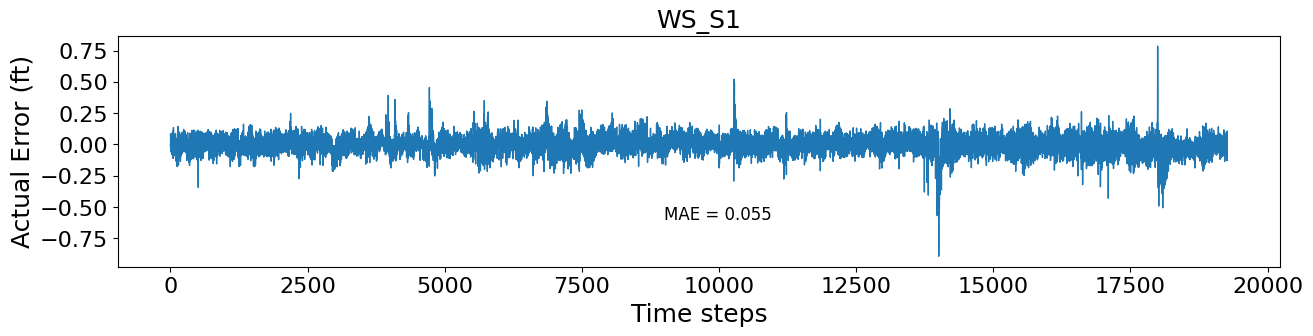

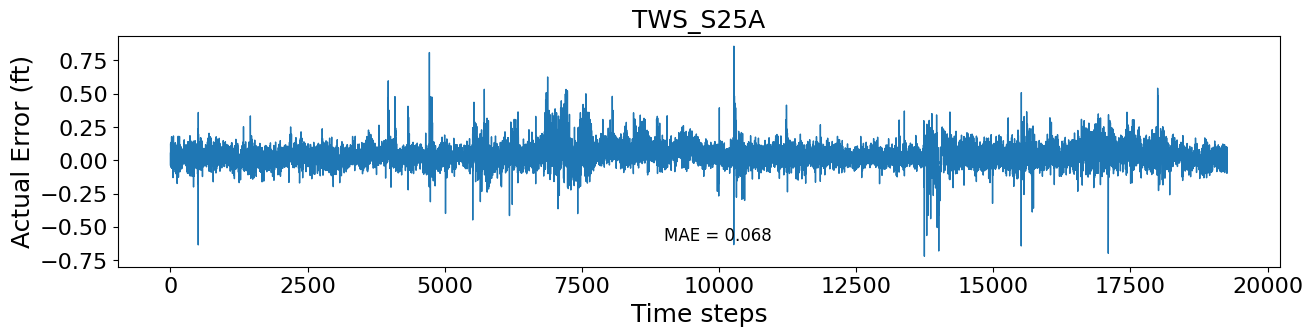

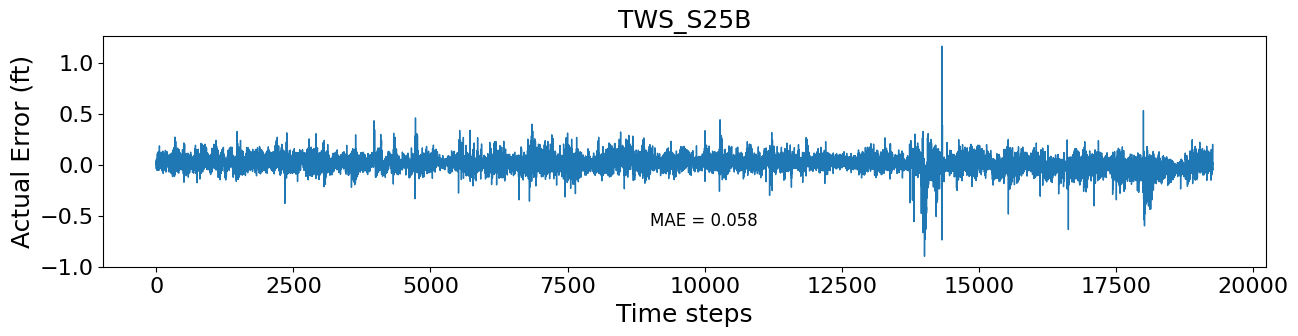

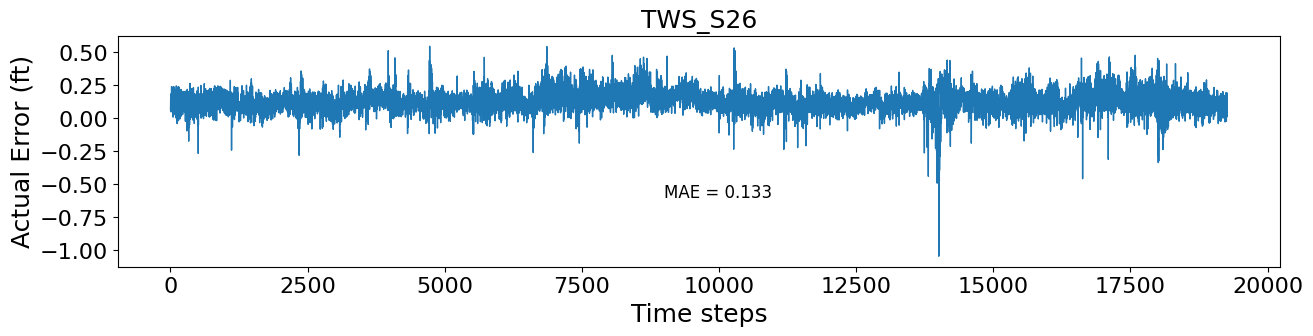

In [12]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [13]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
12
(19268,)
24
(19268,)
31
(19268,)
12


In [14]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
2
(19268,)
16
(19268,)
4
(19268,)
7


In [15]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
10
(19268,)
8
(19268,)
27
(19268,)
5
